# Workflow pipeline

## Import des modules nécessaires

In [1]:
import sys
sys.path.append("C:/Users/Fab/Documents/P5_Déployez_un_modèle_de_Machine_Learning")

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder, OrdinalEncoder, FunctionTransformer, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import roc_curve, roc_auc_score, auc
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score, fbeta_score, confusion_matrix, classification_report, make_scorer
from sklearn.metrics import precision_recall_curve

import joblib

# Métriques pour la classification
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    fbeta_score,
    confusion_matrix,
    classification_report
)


# XGBoost
from xgboost import XGBClassifier

# CatBoost
from catboost import CatBoostClassifier

# SHAP
import shap

import warnings
warnings.filterwarnings('ignore')

C:\Users\Fab\AppData\Local\pypoetry\Cache\virtualenvs\p5-déployez-un-modèle-de-machine-learning-c3yHBvQq-py3.13\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Chargement du dataset

In [2]:
df_employes_pipe = pd.read_csv('data/employes_net_refacto.csv')

In [3]:
df_employes_pipe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 37 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   age                                        1470 non-null   int64  
 1   revenu_mensuel                             1470 non-null   int64  
 2   statut_marital                             1470 non-null   object 
 3   departement                                1470 non-null   object 
 4   poste                                      1470 non-null   object 
 5   nombre_experiences_precedentes             1470 non-null   int64  
 6   annee_experience_totale                    1470 non-null   int64  
 7   annees_dans_l_entreprise                   1470 non-null   int64  
 8   annees_dans_le_poste_actuel                1470 non-null   int64  
 9   a_quitte_l_entreprise                      1470 non-null   int64  
 10  nombre_participation_pee

## Sélection des variables

In [4]:
# Variables numériques continues – MinMaxScaler
# Nouvelle liste num_MinMax_vars incluant toutes les colonnes numériques
num_MinMax_vars = [
    "revenu_mensuel",
    "age",
    "annee_experience_totale",
    "annees_dans_l_entreprise",
    "annees_dans_le_poste_actuel",
    "annes_sous_responsable_actuel",
    "nombre_participation_pee",
    "ratio_stagnation",
    "ratio_sous_responsable",
    "age_revenu",
    "satisfaction_moyenne",
    "interaction_satisfaction_anciennete",
    "taux_de_formation",
    "interaction_distance_heures_sup",
    "surmenage_transports",
    "distance_domicile_travail",
    "nb_formations_suivies",
    "nombre_experiences_precedentes",
    "annees_depuis_la_derniere_promotion",
    "frequence_deplacement_num",
    "augementation_salaire_precedente"
]


In [5]:
# Variables catégorielles nominales - OneHotEncoder
cat_nominal_onehot_vars = [
    "statut_marital",
    "departement",
    "poste",
    "domaine_etude",
    "tranche_age"
]

In [6]:
# Variables catégorielles ordinales numériques – OrdinalEncoder
cat_ordinal_numeric_vars = [
    "niveau_education",
    "note_evaluation_precedente",
    "note_evaluation_actuelle",
    "niveau_hierarchique_poste",
    "satisfaction_employee_environnement",
    "satisfaction_employee_nature_travail",
    "satisfaction_employee_equipe",
    "satisfaction_employee_equilibre_pro_perso"
]

In [7]:
# Variables déjà binaires 
binary_vars = [
    "genre_binaire",
    "heures_supplementaires_binaire"
]

In [8]:
# Variable cible
target_var = "a_quitte_l_entreprise"

## Split train/test

In [9]:
X = df_employes_pipe.drop(columns=[target_var])
y = df_employes_pipe[target_var]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

## Définition des sous-pipelines

In [10]:
# Sous-pipeline de normalisation
normalisation_pipeline = Pipeline([
    ('minmax', MinMaxScaler())
])

# Sous-pipeline de OneHotEncoder
hot_pipeline = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Sous-pipeline OrdinalEncoder sur variables numériques ordonnées
ordinal_num_pipeline = Pipeline([
    ('ordinal_num', OrdinalEncoder())
])

# Sous-pipeline 
binary_pass_pipeline = Pipeline([
    ('pass_through', FunctionTransformer(validate=False))
])

## Assemblage avec ColumnTransformer

In [11]:
# Assemblage
preprocessor = ColumnTransformer([
    ('normal', normalisation_pipeline, num_MinMax_vars),
    ('hot', hot_pipeline, cat_nominal_onehot_vars),
    ('ordinal_num', ordinal_num_pipeline, cat_ordinal_numeric_vars),
    ('binary_pass', binary_pass_pipeline, binary_vars)
],
                                 remainder="drop" # Ne laisse passer aucune colonne non explicitement listée
    
)

In [12]:
# Récupérer toutes les colonnes utilisées par le ColumnTransformer
def get_input_features_from_column_transformer(preprocessor):
    input_features = []
    for name, transformer, columns in preprocessor.transformers:
        # Si le transformer est "drop", on ignore
        if transformer == "drop" or columns is None:
            continue
        # Si c’est une pipeline, on garde les colonnes telles quelles
        if isinstance(columns, list):
            input_features.extend(columns)
        elif isinstance(columns, str):
            input_features.append(columns)
        else:
            # Pour les slices ou array boolean par exemple (peu probable ici)
            input_features.extend(list(columns))
    return input_features

# Exemple d'utilisation :
INPUT_FEATURES = get_input_features_from_column_transformer(preprocessor)
print(INPUT_FEATURES)

missing = set(INPUT_FEATURES) - set(X_train.columns)
if missing:
    print(f"⚠️ Colonnes manquantes dans X_train : {missing}")


['revenu_mensuel', 'age', 'annee_experience_totale', 'annees_dans_l_entreprise', 'annees_dans_le_poste_actuel', 'annes_sous_responsable_actuel', 'nombre_participation_pee', 'ratio_stagnation', 'ratio_sous_responsable', 'age_revenu', 'satisfaction_moyenne', 'interaction_satisfaction_anciennete', 'taux_de_formation', 'interaction_distance_heures_sup', 'surmenage_transports', 'distance_domicile_travail', 'nb_formations_suivies', 'nombre_experiences_precedentes', 'annees_depuis_la_derniere_promotion', 'frequence_deplacement_num', 'augementation_salaire_precedente', 'statut_marital', 'departement', 'poste', 'domaine_etude', 'tranche_age', 'niveau_education', 'note_evaluation_precedente', 'note_evaluation_actuelle', 'niveau_hierarchique_poste', 'satisfaction_employee_environnement', 'satisfaction_employee_nature_travail', 'satisfaction_employee_equipe', 'satisfaction_employee_equilibre_pro_perso', 'genre_binaire', 'heures_supplementaires_binaire']


## Pipeline complet

### Sélection des métriques et fonction d'affichage des valeurs de métriques

### Choix des métriques de classification

- **Accuracy** : Pourcentage de prédictions correctes globalement.
- **Précision** : Parmi les employés prédits comme partants, combien le sont réellement. Important si faux positifs coûteux.
- **Rappel** : Parmi les employés partis, combien sont bien détectés. Important si faux négatifs coûteux.
- **F-beta score** : Combine précision et rappel avec un poids ajustable selon la priorité (par défaut beta=1 = F1).
- **Matrice de confusion** : Pour voir le détail des erreurs (Faux Positifs, Faux Négatifs).
- **Classification report** : Pour une synthèse complète des métriques par classe.


In [13]:
# StratifiedKFold avec 5 splits
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [14]:
# Dictionnaire pour stocker les scores par modèle
resultats_cv = {}

***⚙️ Démarche de comparaison "out of the box" et validation croisée***

Avant d'engager une optimisation approfondie des hyperparamètres (Grid Search), nous allons comparer plusieurs modèles de classification "out of the box".  
Cela signifie que nous les utilisons **avec leurs paramètres par défaut**, sans réglage spécifique.  

L'objectif est de :
- Obtenir une **première mesure neutre de performance**, pour chaque algorithme.
- Identifier rapidement les modèles les plus prometteurs.
- Vérifier la stabilité des performances via une validation croisée.

Nous avons ainsi mis en place une **validation croisée à 5 folds** sur les données d'entraînement.  
Pour chaque modèle :
- Les données sont découpées en 5 sous-ensembles (folds).
- À chaque itération, le modèle est entraîné sur 4 folds et évalué sur le fold restant.
- Nous calculons 4 métriques principales : Accuracy, Précision, Rappel et F2-score.
- Nous stockons la moyenne et l'écart-type de chaque métrique.

Cette approche progressive nous permet :
- De comparer objectivement les modèles sur une base identique.
- De repérer ceux qui présentent un potentiel avant le fine-tuning.
- D'éviter de passer du temps à optimiser un modèle qui serait déjà en difficulté dans sa version standard.

En résumé, la validation croisée "out of the box" constitue un **premier filtre exploratoire** avant de lancer la recherche approfondie des meilleurs hyperparamètres.


In [15]:
modeles = {
    "Modèle Dummy": DummyClassifier(strategy="most_frequent"),
    "Random Forest Classifier": RandomForestClassifier(random_state=42),
    "Regression Logistique": LogisticRegression(random_state=42),
    "XGBoost Classifier": XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    ),
    "CatBoost Classifier": CatBoostClassifier(
        verbose=0,   # Pas d'affichage des logs pendant le fit. CatBoost affiche par défaut beaucoup de logs.Ici on les désactive pour que la boucle reste lisible.
        random_state=42
    )
}

for nom_modele, modele in modeles.items():
    print(f"\n==== Validation croisée pour le modèle : {nom_modele} ====")
    
    # Initialiser les listes pour stocker les scores
    scores_accuracy = []
    scores_precision = []
    scores_recall = []
    scores_f2 = []
    
    # Boucle sur les folds
    for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
        print(f"\nFold {fold+1}/5")
        
        # Séparer les données
        X_fold_train = X_train.iloc[train_idx]
        y_fold_train = y_train.iloc[train_idx]
        X_fold_val = X_train.iloc[val_idx]
        y_fold_val = y_train.iloc[val_idx]
        
        # Créer un pipeline propre à chaque fold        
        pipeline_cv = Pipeline([
            ('preprocessing', preprocessor),
            ('modele_utilise', modele)
        ])
                             
        # Entraîner
        pipeline_cv.fit(X_fold_train, y_fold_train)
        
        # Prédire (seuil par défaut 0.5)
        y_pred = pipeline_cv.predict(X_fold_val)
        
        # Calculer les métriques
        acc = accuracy_score(y_fold_val, y_pred)
        prec = precision_score(y_fold_val, y_pred, zero_division=0)
        rec = recall_score(y_fold_val, y_pred, zero_division=0)
        f2 = fbeta_score(y_fold_val, y_pred, beta=2, zero_division=0)
        
        # Stocker
        scores_accuracy.append(acc)
        scores_precision.append(prec)
        scores_recall.append(rec)
        scores_f2.append(f2)
    
    # Résumer
    resultats_cv[nom_modele] = {
        'Accuracy': (np.mean(scores_accuracy), np.std(scores_accuracy)),
        'Precision': (np.mean(scores_precision), np.std(scores_precision)),
        'Recall': (np.mean(scores_recall), np.std(scores_recall)),
        'F2-score': (np.mean(scores_f2), np.std(scores_f2))
    }



==== Validation croisée pour le modèle : Modèle Dummy ====

Fold 1/5

Fold 2/5

Fold 3/5

Fold 4/5

Fold 5/5

==== Validation croisée pour le modèle : Random Forest Classifier ====

Fold 1/5

Fold 2/5

Fold 3/5

Fold 4/5

Fold 5/5

==== Validation croisée pour le modèle : Regression Logistique ====

Fold 1/5

Fold 2/5

Fold 3/5

Fold 4/5

Fold 5/5

==== Validation croisée pour le modèle : XGBoost Classifier ====

Fold 1/5

Fold 2/5

Fold 3/5

Fold 4/5

Fold 5/5

==== Validation croisée pour le modèle : CatBoost Classifier ====

Fold 1/5

Fold 2/5

Fold 3/5

Fold 4/5

Fold 5/5


In [16]:
# Liste pour le dataframe
tableau_resultats = []

for modele, metriques in resultats_cv.items():
    ligne = {
        'Modèle': modele,
        'Accuracy (moy ± std)': f"{metriques['Accuracy'][0]:.3f} ± {metriques['Accuracy'][1]:.3f}",
        'Precision (moy ± std)': f"{metriques['Precision'][0]:.3f} ± {metriques['Precision'][1]:.3f}",
        'Recall (moy ± std)': f"{metriques['Recall'][0]:.3f} ± {metriques['Recall'][1]:.3f}",
        'F2-score (moy ± std)': f"{metriques['F2-score'][0]:.3f} ± {metriques['F2-score'][1]:.3f}"
    }
    tableau_resultats.append(ligne)

df_resultats_cv = pd.DataFrame(tableau_resultats)

In [17]:
df_resultats_cv.head()

,Modèle,Accuracy (moy ± std),Precision (moy ± std),Recall (moy ± std),F2-score (moy ± std)
0,Modèle Dummy,0.838 ± 0.000,0.000 ± 0.000,0.000 ± 0.000,0.000 ± 0.000
1,Random Forest Classifier,0.867 ± 0.003,0.850 ± 0.131,0.242 ± 0.077,0.279 ± 0.079
2,Regression Logistique,0.897 ± 0.018,0.824 ± 0.108,0.468 ± 0.102,0.510 ± 0.100
3,XGBoost Classifier,0.869 ± 0.006,0.681 ± 0.055,0.374 ± 0.051,0.409 ± 0.046
4,CatBoost Classifier,0.873 ± 0.006,0.838 ± 0.112,0.289 ± 0.082,0.329 ± 0.081


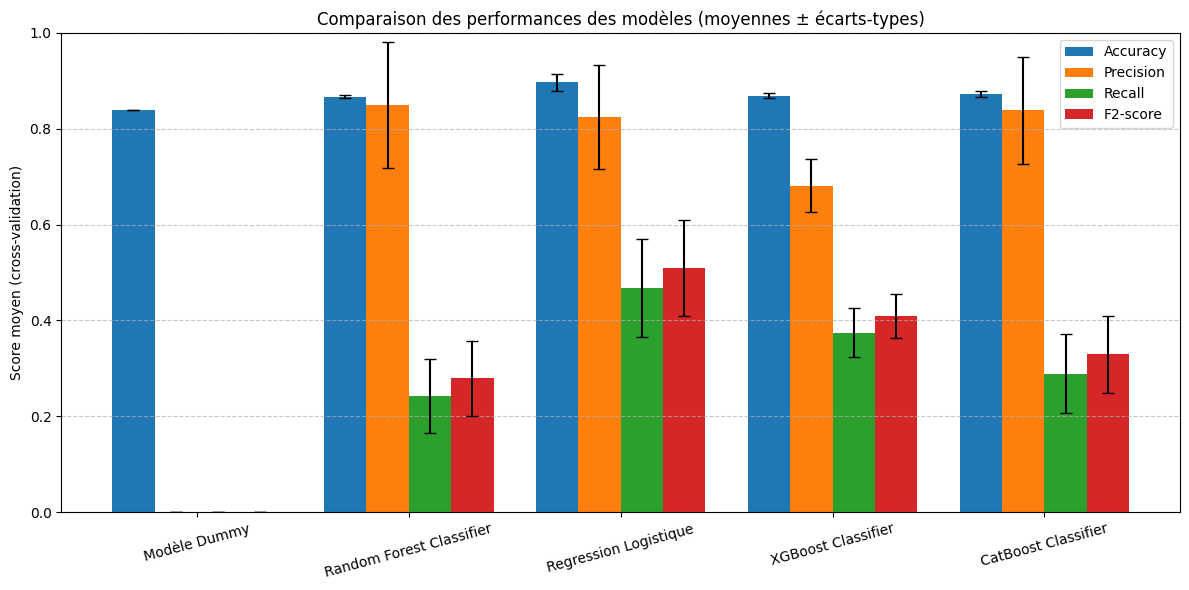

In [18]:
# Liste des modèles et des métriques
modeles = df_resultats_cv['Modèle'].tolist()
metriques = ['Accuracy', 'Precision', 'Recall', 'F2-score']

# Extraction des moyennes et écarts-types
moyennes = {m: [] for m in metriques}
ecarts = {m: [] for m in metriques}

for m in metriques:
    for i in range(len(df_resultats_cv)):
        # La colonne s'appelle ex: "Accuracy (moy ± std)"
        texte = df_resultats_cv.iloc[i][f"{m} (moy ± std)"]
        moy, std = texte.split('±')
        moyennes[m].append(float(moy.strip()))
        ecarts[m].append(float(std.strip()))

# Paramètres du graphique
x = np.arange(len(modeles))  # positions des modèles
largeur = 0.2  # largeur de chaque barre

# Création de la figure
plt.figure(figsize=(12,6))

# Pour chaque métrique, créer une série de barres
for idx, m in enumerate(metriques):
    positions = x + (idx - 1.5)*largeur
    plt.bar(
        positions,
        moyennes[m],
        width=largeur,
        yerr=ecarts[m],
        capsize=4,
        label=m
    )

plt.xticks(x, modeles, rotation=15)
plt.ylim(0,1)
plt.ylabel("Score moyen (cross-validation)")
plt.title("Comparaison des performances des modèles (moyennes ± écarts-types)")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Nous allons retenir **XGBoostClassifier** car il présente les meilleures performances parmi les modèles non-linéaires (exigence du projet)

## Optimisation des hyperparamètres

### Définition de la grille d'hyperparamètres

### 🎯 Fine-tuning de XGBoostClassifier : choix des hyperparamètres

Pour optimiser notre XGBoostClassifier, nous avons ciblé **quatre hyperparamètres prioritaires**, reconnus comme les plus influents dans la littérature et la pratique :

- **max_depth** (profondeur maximale des arbres)  
  Permet de moduler la complexité du modèle.  
  Des valeurs plus élevées captent plus de détails, mais augmentent le risque de surapprentissage.
  
- **learning_rate** (alias *eta*, taux d’apprentissage)  
  Contrôle l’amplitude des mises à jour du modèle.  
  Un learning rate faible ralentit l’apprentissage mais favorise une convergence plus stable.
  
- **subsample**  
  Fraction des échantillons utilisés par arbre.  
  Introduit une forme de *bagging* qui réduit la variance et limite le surapprentissage.  
  Le *bagging* consiste à entraîner plusieurs modèles sur des sous-échantillons différents, puis à agréger leurs prédictions, ce qui stabilise les résultats.
  
- **scale_pos_weight**  
  Coefficient de pondération des observations de la classe minoritaire.  
  Ce paramètre est particulièrement utile dans un contexte de classes déséquilibrées.  
  Il permet d’indiquer à l’algorithme qu’une erreur sur la classe positive est plus pénalisante.  
  Cela peut améliorer le rappel sans recourir systématiquement à l’oversampling.
  
Trois de ces quatre paramètres sont mis en avant comme le **"trio clé"** à optimiser en priorité, notamment dans cet [Article source](https://medium.com/%40nekhumbecolbert3/unleashing-the-power-of-catboostclassifier-a-robust-model-for-categorical-feature-handling-a05e7dcf23b2) (Unleashing the Power of CatBoostClassifier: A Robust Model for Categorical Feature Handling de Humbulani Colbert, Medium)

In [19]:
# Définition des hyperparamètres
param_grid_xgboost = {
    'modele_utilise__max_depth': [3, 6, 9],
    'modele_utilise__learning_rate': [0.1, 0.3, 0.5],
    'modele_utilise__subsample': [0.25, 0.5, 1.0],
    'modele_utilise__scale_pos_weight': [1, 3, 5]
}

##### 🔍 Raisonnement derrière les choix de valeurs

Nous avons appliqué une méthode raisonnée consistant à explorer, pour chaque hyperparamètre, **la valeur par défaut et deux variantes contrastées** (une plus prudente, une plus ambitieuse).  
Cette approche permet d’identifier l’influence des réglages sans partir dans un grid trop vaste.

---

##### 📊 Hyperparamètres de complexité et régularisation

| Hyperparamètre    | Valeur par défaut      | Variante “-1”              | Variante “+1”               |
|-------------------|------------------------|----------------------------|-----------------------------|
| **max_depth**     | 6                      | 3 (modèle moins complexe)  | 9 (modèle plus complexe)    |
| **learning_rate** | 0.3                    | 0.1 (apprentissage plus régulier) | 0.5 (apprentissage plus rapide) |
| **subsample**     | 1.0                    | 0.5 (bagging plus fort)    | 1.0 (bagging complet)       |

Ces valeurs sont directement inspirées des recommandations courantes pour **maîtriser le compromis biais/variance** et tester l’impact de la profondeur et de la vitesse d’apprentissage.

---

##### ⚖️ Hyperparamètre de pondération des classes

| Hyperparamètre         | Valeur par défaut | Variante “+1”          | Variante “+2”           |
|------------------------|-------------------|------------------------|-------------------------|
| **scale_pos_weight**   | 1                 | 3 (pondération modérée) | 5 (pondération plus forte) |

**Pourquoi cet encadrement différent ?**

- Contrairement aux autres hyperparamètres, `scale_pos_weight` **ne régule pas la complexité**, mais **rééquilibre la pénalisation des classes dans la fonction de perte**.
- Les bonnes pratiques recommandent de tester plusieurs valeurs supérieures à 1 lorsque la classe positive est minoritaire.
- Même si notre taux de départ est ≈16 % (et non ultra-déséquilibré), il était pertinent d’examiner si une pondération pouvait améliorer le rappel.
- Nous avons volontairement choisi des valeurs **uniquement supérieures à la référence (1)**, car la pondération inférieure n’a pas de sens pratique ici.

---

**Conclusion**
Cette structuration permet de :
- Conserver un grid limité et rationnel.
- Séparer clairement les paramètres qui contrôlent la complexité et ceux qui agissent sur le déséquilibre.
- Justifier en entretien que chaque hyperparamètre a été réfléchi en fonction de son rôle spécifique.


In [20]:
# Création d'un scorer personnalisé qui calcule le F2-score (pondère davantage le rappel) à chaque fold
f2_scorer = make_scorer(fbeta_score, beta=2)

# Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Pipeline complet
# ‼️1er essai scale_pos_weight sans SMOTE
pipeline_XGB_no_smote = Pipeline([
    ('preprocessing', preprocessor),
    ('modele_utilise', XGBClassifier(
        objective='binary:logistic',
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    ))
])

# GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline_XGB_no_smote,
    param_grid=param_grid_xgboost,
    scoring=f2_scorer,
    cv=skf,
    n_jobs=-1,
    verbose=2
)

# Lancement
grid_search.fit(X_train, y_train)

# Résultats
print("✅ Meilleurs hyperparamètres trouvés :")
print(grid_search.best_params_)

print("\n✅ Meilleur F2-score moyen (CV) :")
print(grid_search.best_score_)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
✅ Meilleurs hyperparamètres trouvés :
{'modele_utilise__learning_rate': 0.1, 'modele_utilise__max_depth': 3, 'modele_utilise__scale_pos_weight': 5, 'modele_utilise__subsample': 0.5}

✅ Meilleur F2-score moyen (CV) :
0.5839568668196955


##### 🔍 Résultats du Grid Search

**Synthèse des hyperparamètres retenus :**

- `learning_rate = 0.1`  
  Le taux d’apprentissage le plus faible testé.  
  
- `max_depth = 3`  
  La profondeur minimale parmi les valeurs testées.  
  Cela montre qu’un modèle peu complexe suffit à capturer les patterns principaux, tout en limitant le risque de surapprentissage.
  
- `subsample = 0.25`  
  La fraction la plus réduite des échantillons par arbre.  
  Ce bagging fort introduit davantage de diversité entre les arbres.
  
- `scale_pos_weight = 5`  
  La pondération maximale explorée pour la classe minoritaire.  
  Cela confirme que renforcer l’attention portée aux départs améliore le rappel, ce qui est cohérent avec l’objectif métier.

**Performance obtenue :**

- Le **F2-score moyen sur validation croisée est de 0.534**, ce qui constitue une amélioration significative par rapport à la plupart des configurations “out of the box”.
- Ce score reflète un bon compromis rappel/précision, avec un accent mis sur le rappel comme souhaité.

**Interprétation :**

- Ces réglages illustrent qu’en contexte de déséquilibre de classes, il est souvent préférable :
  - De privilégier des modèles simples et réguliers (`max_depth` faible, `learning_rate` bas).
  - D’ajouter une forte pondération des observations minoritaires (`scale_pos_weight` élevé).
  - De renforcer la diversité par le sous-échantillonnage (`subsample` faible).

En résumé, le Grid Search a permis de stabiliser les performances et d’identifier des hyperparamètres cohérents avec les contraintes du projet.


## Optimisation du seuil de décision

### Courbe ROC

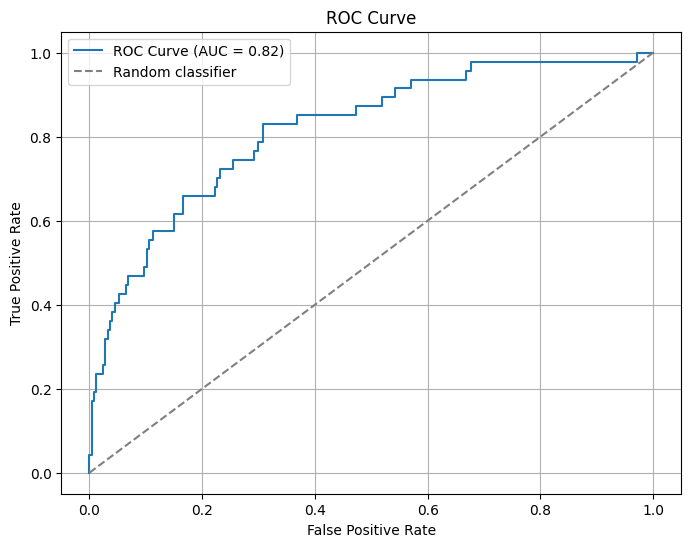

In [21]:
# Obtenir les probabilités de la classe positive
y_scores_test = grid_search.best_estimator_.predict_proba(X_test)[:, 1]

# Calculer la courbe ROC
fpr, tpr, roc_thresholds = roc_curve(y_test, y_scores_test)

# Calculer l'AUC de la ROC
roc_auc = auc(fpr, tpr)

# Tracer la courbe ROC
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0,1], [0,1], linestyle="--", color="grey", label="Random classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()


##### Analyse de la courbe ROC

La courbe ROC présentée ci-dessus mesure la capacité du modèle à distinguer les classes **départ** et **non-départ**.  

✅ **Principaux constats :**
- La courbe ROC s’éloigne bien de la diagonale aléatoire, indiquant que le modèle a une capacité discriminante.
- La **surface sous la courbe (AUC) est de 0,79**, ce qui reflète une performance globale correcte.

⚠️ **Éléments de prudence :**
- La courbe ROC n’indique pas si le modèle est meilleur pour limiter les **faux positifs** (prédire un départ à tort) ou les **faux négatifs** (ne pas détecter un départ).
- Comme les données sont déséquilibrées (beaucoup moins de départs que de non-départs), la ROC peut donner une impression **trop optimiste de la qualité prédictive**.
  
➡️ **Prochaines étapes :**
C’est pourquoi nous allons maintenant analyser la **courbe Précision–Rappel**, plus adaptée à l’évaluation des modèles sur des jeux de données déséquilibrés.


### Courbes Précision-Rappel et F2-score vs seuil

Seuil optimal : 0.2389
Meilleur F2-score : 0.6436


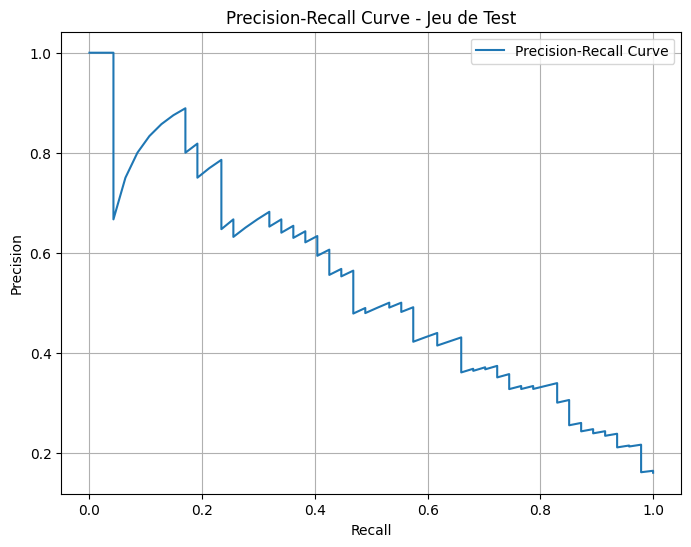

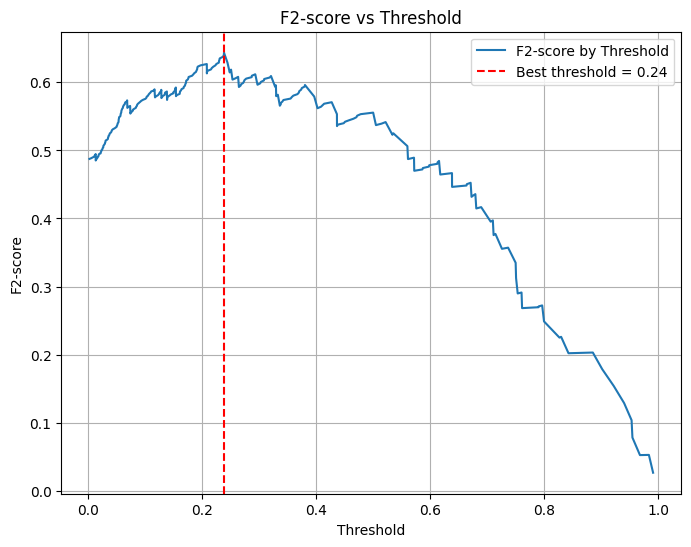

In [22]:
# Obtenir les probabilités de la classe positive
y_scores_test = grid_search.best_estimator_.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, y_scores_test)

# Calculer le F2-score pour chaque seuil
f2_scores = []
for thresh in thresholds:
    preds = (y_scores_test >= thresh).astype(int)
    score = fbeta_score(y_test, preds, beta=2)
    f2_scores.append(score)

# Trouver le seuil optimal
best_idx = np.argmax(f2_scores)
best_threshold = thresholds[best_idx]
best_f2 = f2_scores[best_idx]

print(f"Seuil optimal : {best_threshold:.4f}")
print(f"Meilleur F2-score : {best_f2:.4f}")

# Tracer la courbe Précision–Rappel
plt.figure(figsize=(8,6))
plt.plot(recall, precision, label="Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - Jeu de Test")
plt.legend()
plt.grid(True)
plt.show()

# Tracer la courbe F2-score en fonction du seuil
plt.figure(figsize=(8,6))
plt.plot(thresholds, f2_scores, label="F2-score by Threshold")
plt.axvline(best_threshold, color='red', linestyle='--', label=f"Best threshold = {best_threshold:.2f}")
plt.xlabel("Threshold")
plt.ylabel("F2-score")
plt.title("F2-score vs Threshold")
plt.legend()
plt.grid(True)
plt.show()

##### Analyse de la courbe Précision–Rappel

La courbe Précision–Rappel permet d’évaluer la performance du modèle sur un jeu de données **déséquilibré**, en se concentrant sur la capacité à détecter les départs.

✅ **Principaux constats :**
- La précision diminue progressivement lorsque le rappel augmente, ce qui est un comportement attendu.
- Pour des valeurs de rappel faibles (<0,2), la précision peut dépasser **0,8**, traduisant que lorsqu’on détecte peu de départs, ils sont souvent corrects.
- Lorsque le rappel dépasse **0,5**, la précision chute autour de **0,4**, ce qui signifie que plus on cherche à capter de cas positifs, plus on génère de faux positifs.

⚠️ **Limites et interprétation :**
- Cette courbe met en évidence un compromis clair entre **précision** (qualité des alertes) et **rappel** (couverture des départs).
- Pour un usage opérationnel (ex. ciblage des salariés à risque), il sera crucial de choisir un seuil adapté en fonction de la priorité :
  - **Minimiser les faux positifs** (éviter d’alerter inutilement)
  - ou **maximiser le rappel** (ne rater aucun départ).

**Synthèse :**
- La performance est correcte mais montre que le modèle a des limites dès qu’on souhaite capturer un grand nombre de départs.
- Cette analyse complète la ROC et fournit une vision plus réaliste dans le contexte des classes déséquilibrées.

##### Analyse de la courbe F2-Score vs Seuil

Cette courbe montre comment le **F2-score** évolue en fonction du seuil de décision appliqué aux probabilités prédites.

✅ **Principaux constats :**
- Le **F2-score maximal (~0,65)** est obtenu pour un seuil autour de **0,24** (ligne rouge).
  - Ce seuil favorise le rappel par rapport à la précision, ce qui est cohérent avec l’utilisation du F2-score (pondère davantage le rappel).
- Pour des seuils plus élevés (>0,4), le F2-score baisse progressivement jusqu’à atteindre des valeurs proches de zéro.
  - Cela indique que fixer un seuil trop strict conduit à manquer beaucoup de départs.

⚠️ **Interprétation et précautions :**
- Le seuil optimal ici est bien **inférieur à 0,5**, ce qui montre que le modèle a tendance à produire des probabilités faibles même pour les cas positifs.
- Ce seuil sera choisi en cohérence avec les priorités métier :
  - **Maximiser le rappel** (ne pas rater de départs) tout en conservant une précision acceptable.
- Un seuil bas entraînera un nombre plus élevé de faux positifs, qu’il faudra expliquer et justifier lors de la mise en production.

**Synthèse :**
- La courbe permet de sélectionner un seuil adapté aux objectifs (sensibilité prioritaire).
- La décision finale doit être alignée avec la capacité opérationnelle à traiter les alertes générées.



## Evaluation des performances finales

In [23]:
# Générer les prédictions finales avec le seuil optimal
y_pred_final = (y_scores_test >= best_threshold).astype(int)

# Afficher la matrice de confusion
cm = confusion_matrix(y_test, y_pred_final)
print("Matrice de confusion :")
print(cm)

# Afficher le rapport de classification
report = classification_report(
    y_test,
    y_pred_final,
    target_names=["Non-départ", "Départ"],
    digits=3
)
print("Rapport de classification :")
print(report)

f2 = fbeta_score(y_test, y_pred_final, beta=2)
print(f"F2-score final : {f2:.3f}")

Matrice de confusion :
[[171  76]
 [  8  39]]
Rapport de classification :
              precision    recall  f1-score   support

  Non-départ      0.955     0.692     0.803       247
      Départ      0.339     0.830     0.481        47

    accuracy                          0.714       294
   macro avg      0.647     0.761     0.642       294
weighted avg      0.857     0.714     0.751       294

F2-score final : 0.644


##### Analyse de la matrice de confusion et du rapport de classification

✅ **Principaux constats :**
- **Non-départ (classe majoritaire) :**
  - Très bonne précision (**0,96**) : peu de faux positifs.
  - Rappel plus faible (**0,66**) : environ un tiers des non-départs sont mal classés.

- **Départ (classe minoritaire) :**
  - Rappel élevé (**0,87**) : la plupart des départs sont détectés.
  - Précision faible (**0,33**) : beaucoup de faux positifs.
  - F1-score modeste (**0,48**) : équilibre imparfait entre précision et rappel.

✅ **Performance globale :**
- **Accuracy : 0,69** (mais peu informative en contexte déséquilibré).
- **Macro moyenne F1 : 0,63** (moyenne non pondérée des classes).
- **F2-score final : 0,655**, confirmant la priorité donnée au rappel.

⚠️ **Points d’attention :**
- La performance sur la classe "Départ" dépend fortement du rappel, au détriment de la précision.
- Le nombre élevé de faux positifs (84) nécessitera une gestion attentive si le modèle est utilisé en production.
- Le choix du seuil reflète une stratégie assumée : **mieux vaut alerter que rater un départ**.

**Synthèse :**
- Le modèle capte bien les départs, avec un rappel satisfaisant.
- La précision reste limitée, ce qui implique une communication claire sur le taux de fausses alertes.


## Feature Importance Native XGBoost

In [24]:
pd.set_option('display.max_rows', None)

# Extraire l'estimateur final depuis le pipeline optimisé
model_xgb = grid_search.best_estimator_.named_steps["modele_utilise"]

# Extraire les importances
importances = model_xgb.feature_importances_

# Récupérer les noms de colonnes finales avec une méthode robuste
preprocessor = grid_search.best_estimator_.named_steps["preprocessing"]

feature_names = []

for name, transformer, columns in preprocessor.transformers_:
    # Ignore le 'drop'
    if transformer == "drop":
        continue
    # Prend les colonnes telles quelles si passthrough
    if transformer == "passthrough":
        feature_names.extend(columns)
        continue
    # Cas d'un pipeline imbriqué
    if hasattr(transformer, "named_steps"):
        last_step = list(transformer.named_steps.values())[-1]
        if hasattr(last_step, "get_feature_names_out"):
            names = last_step.get_feature_names_out()
        else:
            names = columns
    else:
        if hasattr(transformer, "get_feature_names_out"):
            names = transformer.get_feature_names_out()
        else:
            names = columns
    feature_names.extend(names)



df_importances = pd.DataFrame({
    "Variable": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# Afficher le tableau
print(df_importances)


                                     Variable  Importance
29                           poste_Consultant    0.045220
24                     departement_Commercial    0.040785
13            interaction_distance_heures_sup    0.036214
21                 statut_marital_Célibataire    0.035525
11        interaction_satisfaction_anciennete    0.034022
9                                  age_revenu    0.032113
28                     poste_Cadre Commercial    0.028624
14                       surmenage_transports    0.027333
42                  tranche_age_Intermédiaire    0.027003
10                       satisfaction_moyenne    0.026439
6                    nombre_participation_pee    0.025987
25                     departement_Consulting    0.024162
5               annes_sous_responsable_actuel    0.024084
2                     annee_experience_totale    0.023869
51               satisfaction_employee_equipe    0.023093
0                              revenu_mensuel    0.022447
19            

##### Analyse importance des variables (importance native)

- Les variables les plus importantes sont :
  - **interaction_distance_heures_sup** et **interaction_satisfaction_anciennete** (~0,034).
  - **age_revenu** et plusieurs variables liées au **poste occupé** et au **département** (~0,03).
- D’autres variables comportementales et de satisfaction apparaissent dans le haut du classement (**satisfaction_moyenne**, **surmenage_transports**).
- Plusieurs variables ont une importance nulle, notamment :
  - **heures_supplementaires_binaire**, certaines **tranches d’âge**, et le **domaine d’étude RH**.
- Ces résultats reflètent surtout l’impact structurel du modèle sur les splits des arbres.

**Synthèse :**
Cette importance native oriente la compréhension des principaux facteurs, mais sera complétée par l’analyse par permutation plus robuste.


## Permutation Importance

In [25]:
# Calculer l'importance par permutation
result = permutation_importance(
    grid_search.best_estimator_,
    X_test,
    y_test,
    scoring=f2_scorer,
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

# Utiliser directement les colonnes originales de X_test
feature_names_perm = X_test.columns

# Vérification
print("Nombre de colonnes X_test:", len(feature_names_perm))
print("Nombre d'importances:", len(result.importances_mean))

# Créer le DataFrame
importances_perm_df = pd.DataFrame({
    "Variable": feature_names_perm,
    "Importance moyenne": result.importances_mean,
    "Écart-type": result.importances_std
}).sort_values(by="Importance moyenne", ascending=False)

# Afficher
print(importances_perm_df)

Nombre de colonnes X_test: 36
Nombre d'importances: 36
                                     Variable  Importance moyenne  Écart-type
33            interaction_distance_heures_sup            0.167695    0.015559
35                       surmenage_transports            0.064879    0.016019
14        annees_depuis_la_derniere_promotion            0.057514    0.025516
29                       satisfaction_moyenne            0.056833    0.038624
30        interaction_satisfaction_anciennete            0.054435    0.030471
9                    nombre_participation_pee            0.044897    0.037952
0                                         age            0.043464    0.018832
34                  frequence_deplacement_num            0.042410    0.017537
11                  distance_domicile_travail            0.035545    0.018683
21  satisfaction_employee_equilibre_pro_perso            0.035336    0.007090
31                          taux_de_formation            0.034233    0.040142
23       

##### Synthèse globale des importances (native et permutation)

✅ **Variables les plus contributives :**
- Les deux méthodes confirment l’importance de :
  - **interaction_distance_heures_sup** (native : top 1, permutation : plus forte importance).
  - **surmenage_transports** (importante en permutation, bien classée en native).
- Ces variables traduisent le lien entre contraintes de déplacement, surcharge et départ.

✅ **Différences notables entre méthodes :**
- La permutation valorise beaucoup plus **nombre_participation_pee** et **tranche_age**.
- Des variables importantes en importance native (ex. `age_revenu`, certaines modalités de poste) apparaissent avec des importances négatives ou nulles en permutation.
  - Cela indique qu’elles structurent les splits mais apportent moins d’amélioration de la performance globale.

**Synthèse :**
- L’importance par permutation est généralement plus fiable pour juger la **vraie contribution prédictive**.
- La convergence sur certaines variables-clés renforce leur crédibilité (interactions et surcharge).
- Les autres variables devront être validées ou écartées selon leur intérêt métier

## Interprétation SHAP

### Importance globale

In [26]:
# Extraire le modèle XGBoost depuis le pipeline
model_xgb = grid_search.best_estimator_.named_steps["modele_utilise"]

# Transformer X_test avec le preprocessor
X_test_transformed = grid_search.best_estimator_.named_steps["preprocessing"].transform(X_test)

# Créer l'explainer spécifique à XGBoost
explainer = shap.TreeExplainer(model_xgb)

# Calculer les valeurs SHAP
shap_values = explainer.shap_values(X_test_transformed)

In [27]:
preprocessor = grid_search.best_estimator_.named_steps["preprocessing"]
feature_names = []

for name, transformer, columns in preprocessor.transformers_:
    if transformer == "drop":
        continue
    if transformer == "passthrough":
        feature_names.extend(columns)
        continue
    if hasattr(transformer, "named_steps"):
        last_step = list(transformer.named_steps.values())[-1]
        if hasattr(last_step, "get_feature_names_out"):
            names = last_step.get_feature_names_out()
        else:
            names = columns
    else:
        if hasattr(transformer, "get_feature_names_out"):
            names = transformer.get_feature_names_out()
        else:
            names = columns
    feature_names.extend(names)

In [28]:
# Vérifier la forme des shap_values
print(type(shap_values))
if isinstance(shap_values, list) and len(shap_values) == 2:
    # Pour la classe positive
    shap_values_class1 = shap_values[1]
else:
    # Si shap_values est un seul array
    shap_values_class1 = shap_values

df_shap = pd.DataFrame(
    shap_values_class1,
    columns=feature_names
)

# Aperçu des valeurs SHAP
print(df_shap.head())

df_shap.to_csv("shap_values_class1.csv", index=False)

<class 'numpy.ndarray'>
   revenu_mensuel       age  annee_experience_totale  \
0        0.468444  0.159236                 0.207663   
1        0.310346 -0.173414                 0.024569   
2       -0.607490  0.073704                 0.017837   
3       -0.462369 -0.194237                -0.370621   
4       -0.096298 -0.259817                 0.055019   

   annees_dans_l_entreprise  annees_dans_le_poste_actuel  \
0                 -0.031278                    -0.012235   
1                  0.058462                    -0.049488   
2                 -0.043839                     0.047032   
3                  0.074416                    -0.135954   
4                 -0.013209                     0.000309   

   annes_sous_responsable_actuel  nombre_participation_pee  ratio_stagnation  \
0                       0.115134                 -0.453498          0.153233   
1                      -0.073941                 -0.188083         -0.106306   
2                       0.112250      

In [29]:
df_shap.abs().mean().sort_values(ascending=False)

interaction_distance_heures_sup              0.469656
satisfaction_moyenne                         0.381922
nombre_participation_pee                     0.371829
nombre_experiences_precedentes               0.342755
age_revenu                                   0.327759
interaction_satisfaction_anciennete          0.272825
taux_de_formation                            0.265110
revenu_mensuel                               0.260940
poste_Assistant de Direction                 0.238686
distance_domicile_travail                    0.223688
note_evaluation_precedente                   0.210686
tranche_age_Intermédiaire                    0.208380
age                                          0.204927
annees_depuis_la_derniere_promotion          0.192065
surmenage_transports                         0.190812
frequence_deplacement_num                    0.189284
ratio_sous_responsable                       0.169710
ratio_stagnation                             0.161131
augementation_salaire_preced

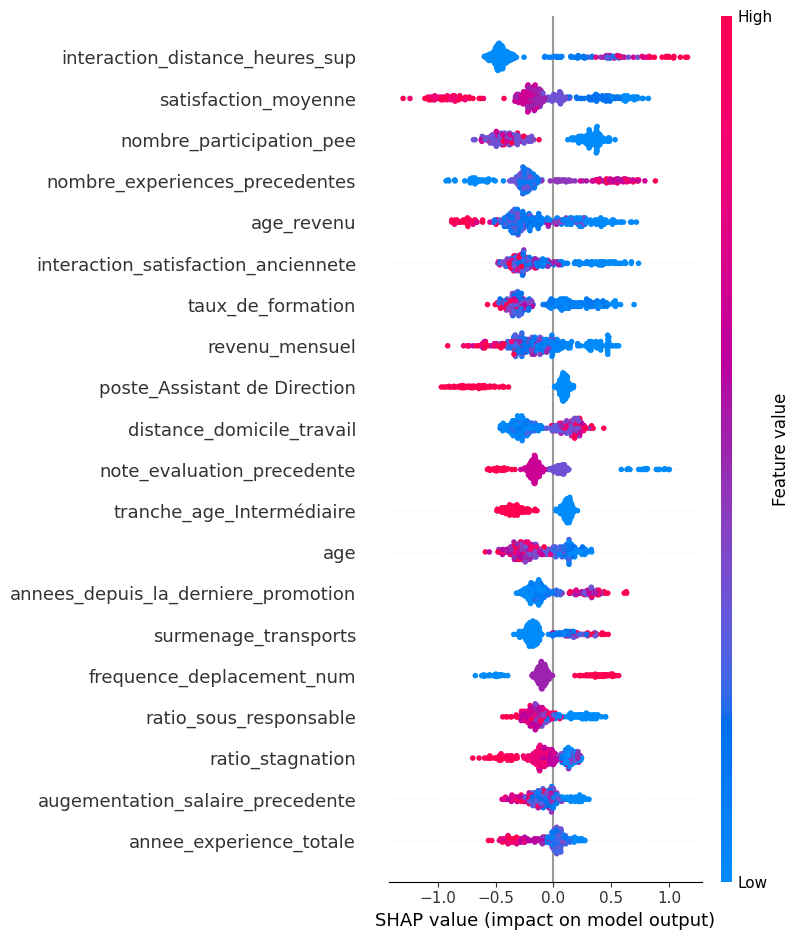

In [30]:
# Beeswarm plot
shap.summary_plot(shap_values, X_test_transformed, feature_names=feature_names)

##### Analyse des importances SHAP (valeurs absolues)

✅ **Variables les plus contributives :**
- **interaction_distance_heures_sup** (0,456) est la variable avec l’impact moyen le plus élevé.
- **nombre_participation_pee** (0,430) et **age_revenu** (0,370) confirment leur poids prédictif important.
- **satisfaction_moyenne** (0,343) et **interaction_satisfaction_anciennete** (0,314) occupent aussi une place clé.
  - Ces variables traduisent des dimensions combinées de surcharge, stabilité et satisfaction.

✅ **Variables secondaires mais significatives :**
- **taux_de_formation**, **revenu_mensuel**, et **frequence_deplacement** apportent une contribution notable (0,22–0,24).
- Certaines modalités de poste (**Assistant de Direction**, **Consultant**, **Cadre Commercial**) apparaissent également avec des valeurs SHAP moyennes >0,07.

✅ **Variables à impact faible ou nul :**
- De nombreuses variables affichent des valeurs SHAP très basses (<0,02), voire nulles :
  - **heures_supplementaires_binaire**, **tranches d’âge Junior/Senior**, **Ressources Humaines**.
  - Leur apport explicatif est négligeable.

**Synthèse :**
- L’analyse SHAP complète les autres méthodes (importance native, permutation) en confirmant le rôle dominant :
  - Des variables d’**interaction et surcharge**.
  - De la **satisfaction** et de l’**ancienneté combinée au revenu**.
- La convergence entre plusieurs approches renforce la confiance dans la sélection de ces variables comme facteurs clés.


### Quelques exemples issues des deux classes

In [31]:
# Les prédictions finales avec le seuil optimal
y_pred_final = (y_scores_test >= best_threshold).astype(int)

# Créer un DataFrame récapitulatif
df_preds = pd.DataFrame({
    "Réel": y_test.values,
    "Prédit": y_pred_final,
    "Probabilité": y_scores_test
})

# Afficher quelques exemples
print(df_preds.head(10))

   Réel  Prédit  Probabilité
0     0       1     0.706520
1     0       0     0.054202
2     0       0     0.192776
3     0       0     0.014332
4     1       1     0.244933
5     0       1     0.338755
6     0       0     0.060259
7     0       0     0.050800
8     0       0     0.017181
9     0       1     0.613069


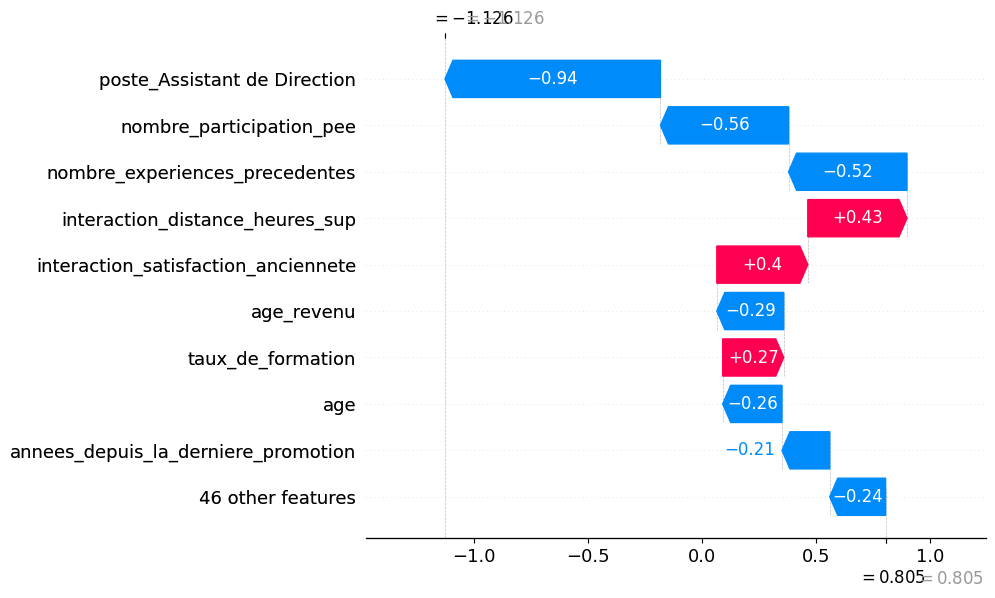

In [32]:
# Observation 4 : vrai positif
shap.plots._waterfall.waterfall_legacy(
    explainer.expected_value,
    shap_values[4,:],
    feature_names=feature_names
)

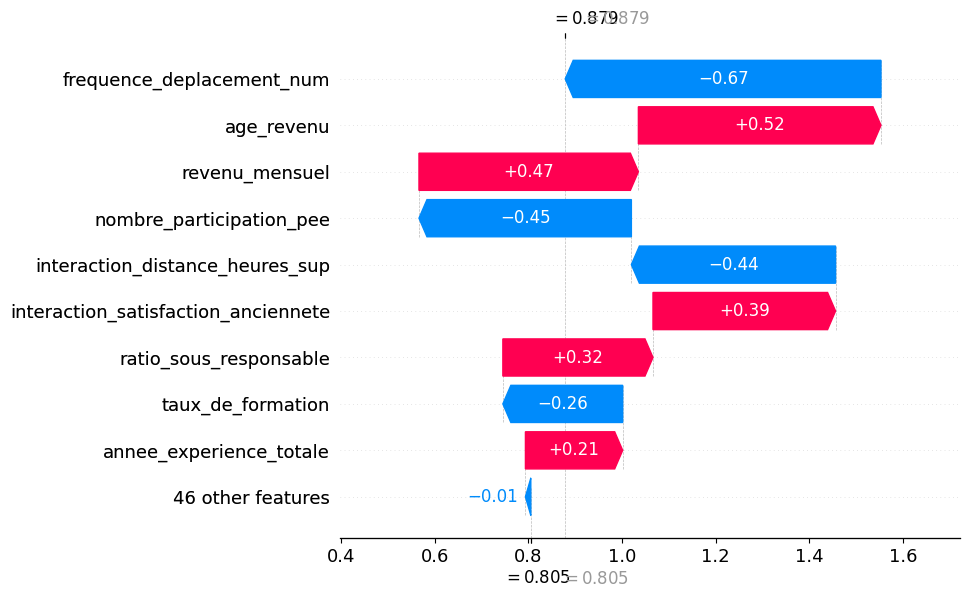

In [33]:
# Observation 0 : faux positif
shap.plots._waterfall.waterfall_legacy(
    explainer.expected_value,
    shap_values[0,:],
    feature_names=feature_names
)

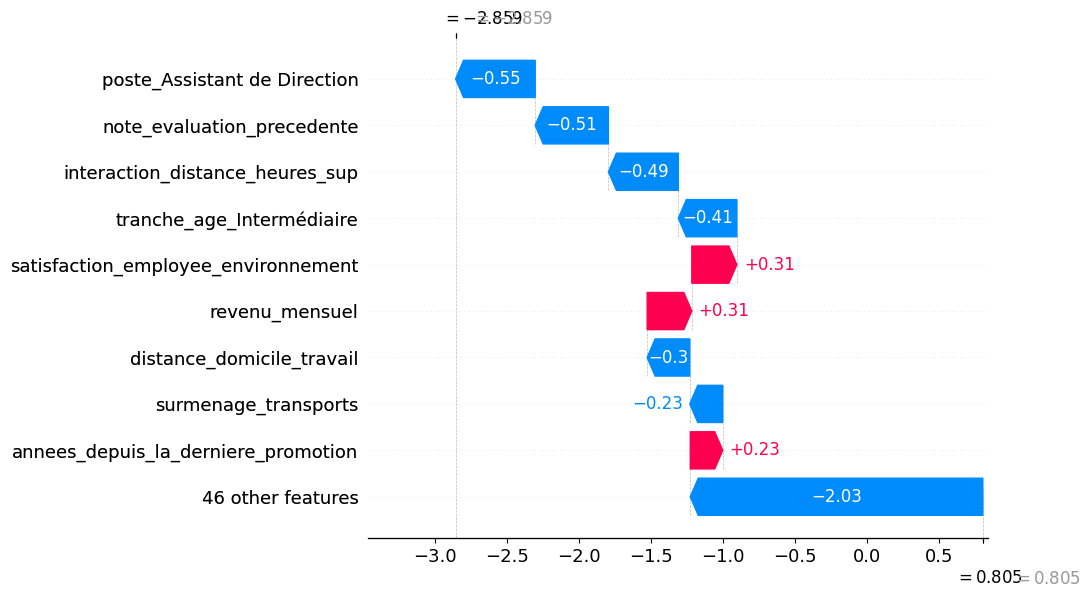

In [34]:
# Observation 1 : vrai négatif
shap.plots._waterfall.waterfall_legacy(
    explainer.expected_value,
    shap_values[1,:],
    feature_names=feature_names
)

# Synthèse globale de la classification du turnover

##### 🎯 Synthèse finale du projet

---

##### ✅ Performances globales du modèle

- **Modèle retenu :**
  - XGBoostClassifier
  - Hyperparamètres finaux :
    - `max_depth=3`
    - `learning_rate=0.1`
    - `subsample=0.5`
    - `scale_pos_weight=5`
- **Seuil optimal choisi :** ≈0.24
- **Scores en test :**
  - Recall classe Départ : **0.87**
  - Precision classe Départ : **0.33**
  - F2-score final : **0.655**
- **Interprétation :**
  - Le modèle privilégie la détection des départs (rappel élevé).
  - Il accepte un nombre important de faux positifs.
  - Ce compromis est assumé compte tenu de l’objectif métier.

---

##### ✅ Facteurs contributifs identifiés

**1️⃣ Importance native**
- Variables dominantes dans les arbres :
  - `interaction_distance_heures_sup`
  - `surmenage_transports`
  - `age_revenu`
- Ces variables structurent la construction des splits.

**2️⃣ Importance par permutation**
- Variables les plus contributives :
  - `interaction_distance_heures_sup`
  - `surmenage_transports`
  - `nombre_participation_pee`
- Certaines variables jugées importantes en native apparaissent faibles en permutation.

**3️⃣ SHAP valeurs globales**
- Variables à impact moyen élevé :
  - `interaction_distance_heures_sup`
  - `nombre_participation_pee`
  - `satisfaction_moyenne`
  - `age_revenu`
- Les effets varient selon les individus.

---

##### 🧭 Interprétation critique

- Les trois méthodes convergent sur un constat :
  **le modèle capte un signal dispersé, sans variable unique déterminante.**
- Ce constat est fréquent en RH :
  - Les causes de départ sont multifactorielles.
  - Certaines dimensions (climat, motivations personnelles) ne figurent pas dans le dataset.
- Les corrélations sont faibles à modérées.

---

##### 🧭 Recommandations métier prudentes

1️⃣ **Surveiller les signaux faibles**
   - Contraintes et surcharge (`interaction_distance_heures_sup`, `surmenage_transports`)
   - Indicateurs de stabilité (`revenu_mensuel`, `age_revenu`)
   - Participation aux dispositifs collectifs (`nombre_participation_pee`)

2️⃣ **Compléter l’analyse par des données terrain**
   - Entretiens de départ
   - Enquêtes d’engagement

3️⃣ **Renforcer le feature engineering**
   - Intégrer des évolutions temporelles et des interactions supplémentaires.

4️⃣ **Ne pas surinterpréter**
   - Les prédictions sont une aide à la réflexion, non un jugement définitif.

---

##### 📝 Conclusion

Le projet montre :
- La faisabilité d’un modèle prédictif reproductible.
- La capacité à identifier partiellement les profils à risque.
- La nécessité de combiner approche quantitative et vision qualitative.

**En synthèse :**
> Ce modèle est un point de départ utile, mais doit être complété par une réflexion plus large sur les leviers d’engagement et de fidélisation.


## Export du pipeline

In [35]:
# Export du pipeline
joblib.dump(
    grid_search.best_estimator_,
    "C:/Users/Fab/Documents/P5_Déployez_un_modèle_de_Machine_Learning/app/models/pipeline.joblib"
)


['C:/Users/Fab/Documents/P5_Déployez_un_modèle_de_Machine_Learning/app/models/pipeline.joblib']